In [24]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import numpy as np
import glob,imp,os,sys
from scipy.interpolate import interp1d
import pyslha
from matplotlib import pyplot as plt

pd.options.mode.chained_assignment = None #Disable copy warnings

In [3]:
def microParser(mfile):
    outputDict = {}
    if not os.path.isfile(mfile):
        print('File %s not found' %mfile)
        return outputDict
    
    with open(mfile,'r') as f:
        output = f.read()
        excludedDD = True
        if 'Not excluded by DD experiments' in output:
            excludedDD =False
        
        #Get block for physical constraints
        physConst = output.split('==== Physical Constraints: =====')[1].split('===')[0]
        obs_dict = {}
        for l in physConst.split('\n'):
            if not l.strip(): continue
            if '=' in l:                
                line = l[:]
                while '=' in line:
                    label = line.split('=',1)[0].strip()
                    line = line.split('=',1)[1]
                    val = line.split()[0].strip() #Get value
                    line = line.replace(val,'',1)
                    try:
                        val = eval(val)
                    except:
                        pass
                    obs_dict[label] = val
            elif 'MassLimits' in l:                
                if l.split()[1].strip() == 'OK':
                    val = True
                else:
                    val = False
                obs_dict['MassLimits'] = val
                break
    
        #Get block for relic density
        relic = output.split('==== Calculation of relic density')[1].split('\n')[1:2]       
        line = relic[0]
        while '=' in line:
            if not line.strip():
                continue
            label = line.split('=',1)[0].strip()
            line = line.split('=',1)[1]
            val = line.split()[0].strip() #Get value
            line = line.replace(val,'',1)
            try:
                val = eval(val)
            except:
                pass
            obs_dict[label] = val
            
            
        #Get block for CDM nucleon cross-section
        CDMxsec = output.split('==== ~o1-nucleon cross sections[pb] ====')[1].split('===')[0]
        CDMxsec = CDMxsec.split('\n')
        for l in CDMxsec:
            l = l.strip()
            if not l: continue
            nucleons = ['proton','neutron']
            for nucleon in nucleons:
                if nucleon in l:
                    l = l.replace(nucleon,'')
                    l = l.strip()
                    l = l.split()
                    labels = ['%s_%s'%(nucleon,v) for v in l[::2]]
                    vals = [eval(v) for v in l[1::2]]
                    for i,label in enumerate(labels):
                        obs_dict[label] = vals[i]
                        
    obs_dict['excludedDD'] = excludedDD
    return obs_dict

In [14]:
#Get Micromegas data:
microFolder = '../EWino/data/micromegas_scanRandom'
slhaFolder = '../EWino/data/slha_scanRandom'
microData = []
for microFile in glob.glob(os.path.join(microFolder,'*.micro')):
    slhaFile = os.path.basename(microFile).replace('.micro','.slha')
    slhaFile = os.path.join(slhaFolder,slhaFile)
    slhaData = pyslha.readSLHAFile(slhaFile)
    mLSP = slhaData.blocks['MASS'][1000022]
    obs_dict = microParser(microFile)
    obs_dict['filename'] = microFile
    obs_dict['mDM'] = mLSP
    microData.append(obs_dict)

In [19]:
#Get Xenon1T exclusion curve:
xenon = np.genfromtxt('Xenon1T.csv',delimiter=',',skip_header=1)
xenon[:,1] = 1e36*xenon[:,1] #convert to pb

xenonF = interp1d(np.log(xenon[:,0]),np.log(xenon[:,1]),
                  bounds_error=False,fill_value="extrapolate") #interpolate in log
xenonUL = lambda mDM: np.exp(xenonF(np.log(mDM)))

In [82]:
excluded = []
allowed = []
for pt in microData:
    mDM = pt['mDM']
    sigUL = xenonUL2(mDM)
    sig = (pt['proton_SI']+pt['neutron_SI'])/2.
    r = sig/sigUL
    if pt['excludedDD']:
        excluded.append([mDM,r,sig])
    else:
        allowed.append([mDM,r,sig])
        
#     if r < 1 and pt['excludedDD']:
#         print(pt['filename'])
#         break
#     print(obs_dict)
#     print(sig)
#     print(r)
#     break

excluded = np.array(excluded)
allowed = np.array(allowed)

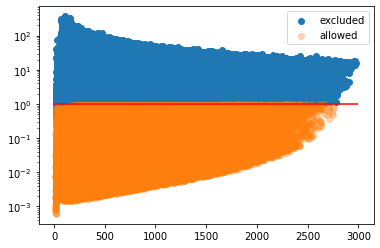

In [83]:
plt.scatter(excluded[:,0],excluded[:,1],label='excluded')
plt.scatter(allowed[:,0],allowed[:,1],label='allowed',alpha=0.3)
plt.hlines(y=1,xmin=0,xmax=3000,color='red')
plt.legend()
plt.yscale('log')
plt.show()

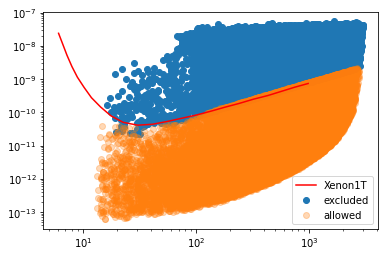

In [84]:
plt.scatter(excluded[:,0],excluded[:,2],label='excluded')
plt.scatter(allowed[:,0],allowed[:,2],label='allowed',alpha=0.3)
plt.plot(xenon[:,0],xenon[:,1],label='Xenon1T',c='red')
# plt.hlines(y=1,xmin=0,xmax=3000)
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.show()

In [75]:
data_1t_lnM = [1.790E+00, 1.885E+00, 2.006E+00, 2.148E+00, 2.297E+00, 2.449E+00, 2.598E+00, 2.783E+00, 2.961E+00, 3.117E+00, 3.302E+00, 3.444E+00, 3.614E+00, 3.796E+00, 4.037E+00, 4.268E+00, 4.581E+00, 4.904E+00, 5.178E+00, 5.441E+00, 5.768E+00, 6.095E+00, 6.369E+00, 6.550E+00, 6.891E+00]
data_1t_lnS = [1.040E+00, 2.794E-02,-1.003E+00,-2.035E+00,-2.888E+00,-3.591E+00,-4.144E+00,-4.717E+00,-5.111E+00,-5.326E+00,-5.458E+00,-5.486E+00,-5.440E+00,-5.375E+00,-5.178E+00,-4.982E+00,-4.711E+00,-4.412E+00,-4.150E+00,-3.925E+00,-3.598E+00,-3.270E+00,-3.009E+00,-2.812E+00,-2.485E+00]

#Get Xenon1T exclusion curve from micromegas:
xenonF2 = interp1d(data_1t_lnM,data_1t_lnS,
                  bounds_error=False,fill_value="extrapolate") #interpolate in log
xenonUL2 = lambda mDM: 1e-8*np.exp(xenonF2(np.log(mDM)))


In [76]:
mDMlist = np.logspace(0,4,100)
vals = []
for m in mDMlist:
    vals.append([m,xenonUL(m),xenonUL2(m)])
    
vals = np.array(vals)

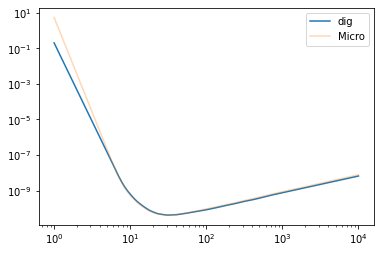

In [77]:
plt.plot(vals[:,0],vals[:,1],label='dig')
plt.plot(vals[:,0],vals[:,2],label='Micro',alpha=0.3)
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.show()

In [72]:
44-36

8